In [1]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 640.0 kB/s eta 0:03:16
   ---------------------------------------- 0.1/124.9 MB 2.0 MB/s eta 0:01:04
   ---------------------------------------- 0.3/124.9 MB 2.9 MB/s eta 0:00:44
   ---------------------------------------- 0.5/124.9 MB 3.2 MB/s eta 0:00:39
   ---------------------------------------- 0.6/124.9 MB 3.1 MB/s eta 0:00:40
   ---------------------------------------- 0.8/124.9 MB 3.2 MB/s eta 0:00:39
   ---------------------------------------- 0.9/124.9 MB 3.2 MB/s eta 0:00:40
   ---------------------------------------- 1.0/124.9 MB 2.9 MB/s eta 0:00:43
   ---------------------------------------- 1.1/124.9 MB 2.9 MB/s eta 0:00:43
   ---------------------------------------- 1.3/124.9 MB 2.9 MB/s eta 0:00:43
   ---------------------------------------- 1.4/124.9 MB 2.9 MB/s eta 0:00:43
   ---------------------------------------- 1.5/124.9 MB 2.8 MB/s eta


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# !where python
# !pip show ruptures


C:\Python312\python.exe
C:\Users\15046\AppData\Local\Programs\Python\Python311\python.exe
Name: ruptures
Version: 1.1.9
Summary: Change point detection for signals in Python.
Home-page: https://github.com/deepcharles/ruptures/
Author: Charles Truong, Laurent Oudre, Nicolas Vayatis
Author-email: charles@doffy.net
License: BSD-2-Clause
Location: C:\Python312\Lib\site-packages
Requires: numpy, scipy
Required-by: 


In [1]:
# import sys
# print(sys.executable)



C:\Users\15046\AppData\Local\Programs\Python\Python311\python.exe


In [4]:
 # !jupyter kernelspec list


Available kernels:
  myenv      C:\Users\15046\AppData\Roaming\jupyter\kernels\myenv
  python3    C:\Users\15046\AppData\Roaming\Python\share\jupyter\kernels\python3


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [8]:
import pandas as pd
import glob

# Path to preprocessed data
file_pattern = "preprocessed_data/partition_id=*.parquet"

# List all matching files
file_list = glob.glob(file_pattern)

# Ensure there are matching files
if not file_list:
    raise FileNotFoundError("No files found matching the pattern!")

# Concatenate all files into a single DataFrame
data = pd.concat([pd.read_parquet(file) for file in file_list], ignore_index=True)

# Sort data by date_id and time_id
data = data.sort_values(by=["date_id", "time_id"]).reset_index(drop=True)

# Preview the loaded data
print(data.head())


   date_id  time_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0        0        0          1  3.889038    0.405433    0.008141    0.406729   
1        0        0          7  1.370613    0.405433    0.008141    0.406729   
2        0        0          9  2.285698    0.405433    0.008141    0.406729   
3        0        0         10  0.690606    0.405433    0.008141    0.406729   
4        0        0         14  0.440570    0.405433    0.008141    0.406729   

   feature_03  feature_04  feature_05  ...  responder_0  responder_1  \
0    0.405782    0.002212    0.851033  ...     0.738489    -0.069556   
1    0.405782    0.002212    0.676961  ...     2.965889     1.190077   
2    0.405782    0.002212    1.056285  ...    -0.864488    -0.280303   
3    0.405782    0.002212    1.139366  ...     0.408499     0.223992   
4    0.405782    0.002212    0.955200  ...    -0.373387    -0.502764   

   responder_2  responder_3  responder_4  responder_5  responder_6  \
0     1.380875  

In [9]:
# Aggregate data by date_id
agg_data = data.groupby('date_id')['responder_6'].agg(['mean', 'std']).reset_index()
agg_data.columns = ['date_id', 'mean_responder', 'volatility_responder']
print(agg_data.head())


   date_id  mean_responder  volatility_responder
0        0       -0.011707              0.529894
1        1       -0.013778              0.812211
2        2       -0.058745              0.797652
3        3       -0.007691              0.968893
4        4        0.033380              0.698249


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

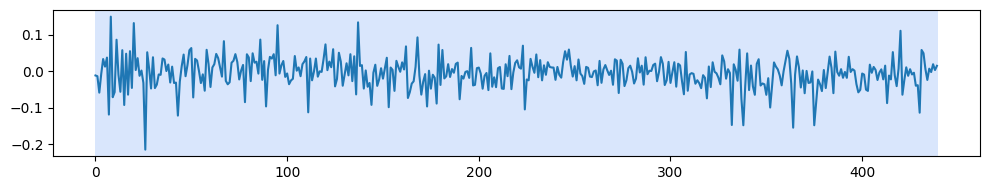

In [10]:
import ruptures as rpt

# Use the mean_responder for change point detection
signal = agg_data['mean_responder'].values

# Detect change points with Pelt algorithm
algo = rpt.Pelt(model="rbf").fit(signal)
breakpoints = algo.predict(pen=10)

# Visualize
rpt.display(signal, breakpoints)


In [11]:
from hmmlearn.hmm import GaussianHMM

# Fit an HMM model to volatility data
X = agg_data[['mean_responder', 'volatility_responder']].fillna(0).values
hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
hmm.fit(X)

# Predict regimes
agg_data['regime'] = hmm.predict(X)
print(agg_data.head())


   date_id  mean_responder  volatility_responder  regime
0        0       -0.011707              0.529894       0
1        1       -0.013778              0.812211       0
2        2       -0.058745              0.797652       0
3        3       -0.007691              0.968893       0
4        4        0.033380              0.698249       0


In [12]:
# Save the regime data
agg_data.to_csv("regime_data.csv", index=False)
print("Regime data saved successfully.")


Regime data saved successfully.


In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Merge regime labels with original data
data = data.merge(agg_data[['date_id', 'regime']], on='date_id')

# Train models for each regime
for regime in data['regime'].unique():
    regime_data = data[data['regime'] == regime]
    X = regime_data.drop(columns=['responder_6', 'weight', 'regime'])
    y = regime_data['responder_6']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Regime {regime} - MSE: {mse}")


Regime 0 - MSE: 0.18175814823805525
Regime 1 - MSE: 0.2650359507187947


In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

# Define the objective function for hyperparameter tuning
def objective(trial, X, y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    model = xgb.XGBRegressor(**params, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    preds = model.predict(X_val)
    return mean_squared_error(y_val, preds)

# Optimize for each regime
for regime in data['regime'].unique():
    regime_data = data[data['regime'] == regime]
    X = regime_data.drop(columns=['responder_6', 'weight', 'regime'])
    y = regime_data['responder_6']
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)
    
    print(f"Best params for Regime {regime}: {study.best_params}")


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

# Define the objective function for hyperparameter tuning
def objective(trial, X, y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    model = xgb.XGBRegressor(**params, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    preds = model.predict(X_val)
    return mean_squared_error(y_val, preds)

# Optimize for each regime
for regime in data['regime'].unique():
    regime_data = data[data['regime'] == regime]
    X = regime_data.drop(columns=['responder_6', 'weight', 'regime'])
    y = regime_data['responder_6']
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)
    
    print(f"Best params for Regime {regime}: {study.best_params}")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

def purged_kfold_validation(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    
    for train_index, test_index in tscv.split(X):
        # Purge 10% of the training set to prevent leakage
        purge_size = int(0.1 * len(train_index))
        train_index = train_index[:-purge_size]
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train and validate model
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        preds = model_clone.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        results.append(mse)
    
    return np.mean(results)

# Example usage with XGBoost
model = xgb.XGBRegressor(random_state=42)
X = data.drop(columns=['responder_6', 'weight', 'regime'])
y = data['responder_6']
average_mse = purged_kfold_validation(model, X, y)
print(f"Average MSE with Purged K-Fold: {average_mse}")


In [ ]:
from sklearn.linear_model import LogisticRegression

# Analyze regime transitions
data['prev_regime'] = data['regime'].shift(1)
data['regime_transition'] = (data['prev_regime'] != data['regime']).astype(int)

# Train a meta-model to predict regime transitions
X_meta = data[['prev_regime', 'regime_transition'] + list(X.columns)]
y_meta = data['responder_6']
meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_meta, y_meta)

# Make predictions
data['meta_predictions'] = meta_model.predict(X_meta)

# Blend predictions from regime-specific models
data['blended_predictions'] = (
    data['meta_predictions'] * 0.5 + data['responder_6'] * 0.5
)
